<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table id="top" class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./06_predicting_sleep.ipynb" title="Predicting Sleep">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">07</td>
    <td style="text-align:right; width:33%;">
      <a href="./08_predicting_anxiety_level.ipynb" title="Predicting Anxiety Level">Next &gt;</a>
    </td>
  </tr>
</table>

# Predicting Stress Level
---

Import libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

---

## Import cleaned data parquet file

Import the cleaned data that was the output of the 1st notebook

In [2]:
df = pd.read_parquet("../data/mental_health_social_media_dataset_cleaned.parquet")

---
## Select Features

In [3]:
# List numeric columns
numeric_features = [
    "age",
    "daily_screen_time_min",
    "social_media_time_min",
    "physical_activity_min",
    "interaction_negative_ratio",
    "sleep_hours",
    "mood_level",
    "anxiety_level"
]

# List categorical columns
categorical_features = ["gender", "platform", "mental_state"]

# List all features
features = numeric_features + categorical_features

# List target variable
target = "stress_level"

# Select features and target variable
data = df[features + [target]].copy()

---
## Train/Test split the data

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target],
    test_size=0.2, random_state=42
)

---
## Build the pipeline

In [5]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearRegression())
])

---
## Fit pipeline

In [6]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


---
## Evaluate the results

In [7]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

MAE: 0.15285490393144724
RMSE: 0.2043374132721809
R²: 0.9638667800358738


MAE ≈ 0.15 - On average, predictions are off by only 0.15 stress points on a 1–10 scale.

RMSE ≈ 0.20 - Most errors fall within + or - 0.20, again very small.

R² ≈ 0.964 The model explains 96.4% of the variation in stress level. This shows stress is highly predictable given the other features in the dataset.


Create scatter chart to compare actaul with predicted:

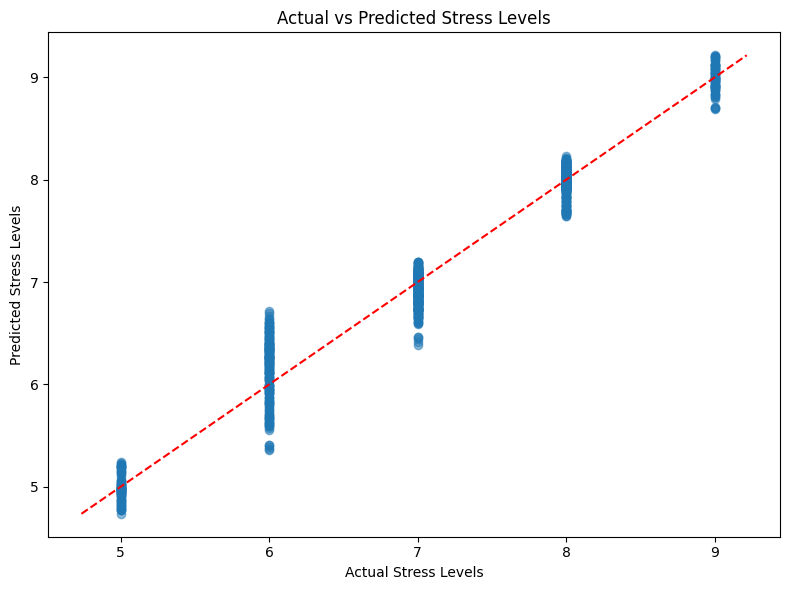

In [8]:
fig = plt.figure(figsize=(8, 6))

# Scatter plot of actual vs predicted stress levels
plt.scatter(y_test, y_pred, alpha=0.5)

# Add labels and title
plt.xlabel("Actual Stress Levels")
plt.ylabel("Predicted Stress Levels")
plt.title("Actual vs Predicted Stress Levels")

# Add a diagonal line for reference
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")

# Show and save the plot
plt.tight_layout()
plt.savefig('../charts/predicting_stress_level_linear_regression_scatter.png')
plt.show()

View the exported png [here](../charts/predicting_stress_level_linear_regression_scatter.png)

What the plot shows:
- The points cluster tightly around the diagonal line.
- There is a small vertical spread.
- No strong deviations above or below the line.


Add a residual chart:

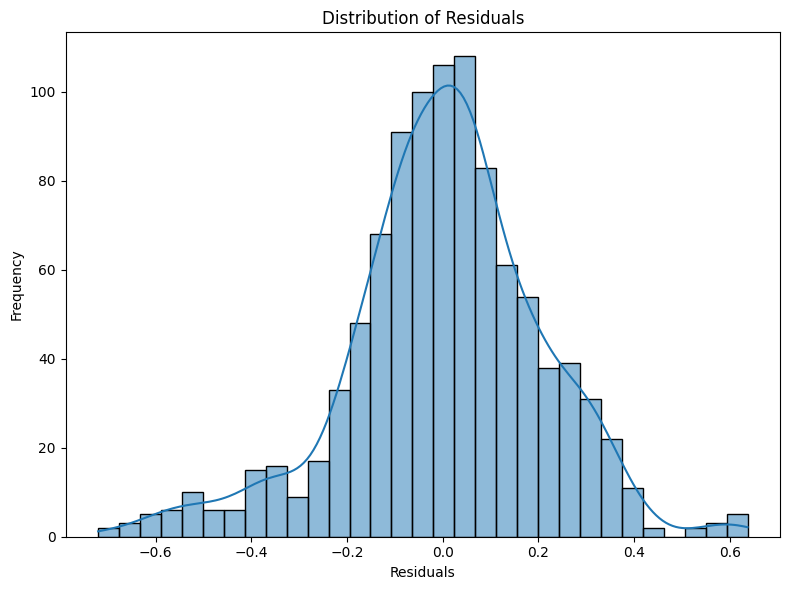

In [9]:
# Calculate residuals
residuals = y_test - y_pred

# Plot the distribution of residuals
plt.figure(figsize=(8, 6))

# Histogram of residuals
sns.histplot(residuals, kde=True)

# Add labels and title
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()

# Show and save the plot
plt.savefig('../charts/predicting_stress_level_linear_regression_residuals.png')
plt.show()

View the exported png [here](../charts/predicting_stress_level_linear_regression_residuals.png)

The residual distribution looks very close to a normal bell curve, centred around zero.

The residual plot shows that the model’s errors are small, evenly distributed.

---
## Save the model

In [10]:
# save the model
joblib.dump(pipeline, '../models/predicting_stress_level_linear_regression_model.pkl')

['../models/predicting_stress_level_linear_regression_model.pkl']

---
## Run the model on unseen data

I am going to use the persona data created on the cluster notebook to make test predictions.

In [11]:
# laod the persona data
cluster_profiles = pd.read_parquet("../data/cluster_profiles.parquet")

# Prepare input data for prediction
persona_input = cluster_profiles.drop(columns=["stress_level"])

# Make predictions for each persona
preds = pipeline.predict(persona_input)

# Combine predictions with cluster profiles
results = cluster_profiles.copy()
results["model_prediction"] = preds

# Display the results
results

,age,daily_screen_time_min,social_media_time_min,sleep_hours,physical_activity_min,interaction_negative_ratio,stress_level,mood_level,anxiety_level,gender,platform,mental_state,model_prediction
cluster,,,,,,,,,,,,,
0,24.568182,423.176573,105.818182,6.882517,17.681818,0.112762,6.624126,6.202797,1.797203,Male,WhatsApp,Stressed,6.617624
1,25.189744,411.379487,149.000000,6.942949,18.857692,0.428205,7.170513,5.747436,2.252564,Female,Facebook,Stressed,7.096664
2,24.178295,422.108527,232.156977,6.888953,17.790698,0.328327,7.674419,5.325581,3.000000,Female,Snapchat,Stressed,7.650685
3,23.417417,435.710961,224.520270,6.820420,16.427177,0.266892,7.759760,5.240240,2.995495,Female,YouTube,Stressed,7.672265
4,50.829574,194.558897,66.328321,8.030576,40.546366,0.000000,5.000000,7.000000,1.000000,Female,Facebook,Healthy,5.017970
5,45.391153,228.046566,121.833527,7.861467,37.190920,0.311021,6.112922,5.989523,2.053551,Male,TikTok,Stressed,6.168282
6,24.166052,425.575646,276.634686,6.871402,17.450185,0.427429,8.512915,4.487085,3.811808,Male,TikTok,Stressed,8.495651


View just the stress level columns:

In [12]:
# display just stress level and model prediction
results[["stress_level", "model_prediction"]]

,stress_level,model_prediction
cluster,,
0,6.624126,6.617624
1,7.170513,7.096664
2,7.674419,7.650685
3,7.759760,7.672265
4,5.000000,5.017970
5,6.112922,6.168282
6,8.512915,8.495651


The regression model also performed very well when tested on the cluster personas.

Each persona’s predicted stress level was extremely close to its actual cluster average, typically within a few hundredths of a point.

This shows that the model generalises cleanly and captures the same patterns we saw earlier in the clustering analysis. High-stress personas are predicted as high stress, low-stress personas remain low, and the relative ordering of clusters is preserved. 

Overall, the model behaves exactly as expected and reflects the strong, structured relationships in the dataset.

---
## Conclusion

The stress prediction model performs extremely well, achieving very low error rates and explaining over 96% of the variation in stress levels. 

The residuals are normally distributed and centred around zero, and the actual vs. predicted plot shows a tight alignment with the ideal line, confirming the model is both accurate and stable. 

When applied to the cluster personas, the model continues to generalise cleanly, producing stress estimates that closely match each persona’s actual average values. 

Overall, the model captures the strong relationships between lifestyle, emotional state, and stress that appeared throughout the earlier analysis, and it provides reliable, consistent predictions that fit perfectly with the structured nature of the dataset.

---
<style>
.noborder td, .noborder th, .noborder table {
    border: none !important;
}
</style>

<table class="noborder" style="width:100%; border-collapse:collapse;">
  <tr>
    <td style="text-align:left; width:33%;">
      <a href="./06_predicting_sleep.ipynb" title="Predicting Sleep">&lt; Previous</a>
    </td>
    <td style="text-align:center; width:33%;">07</td>
    <td style="text-align:right; width:33%;">
      <a href="./08_predicting_anxiety_level.ipynb" title="Predicting Anxiety Level">Next &gt;</a>
    </td>
  </tr>
</table>
<p style="text-align:center;">
  <a href="#top">⬆ Back to top</a>
</p>